In [1]:
import os
import pandas as pd
import numpy as np
import functools
from matplotlib import pylab as plt
from matplotlib.pyplot import figure
from urllib.parse import urlparse

In [2]:
egypt_control = pd.read_csv("../data/egypt_control/experiments.csv")
us_control = pd.read_csv("../data/us_control/experiments.csv")
egypt_control["conn_rst"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CONNECTION_RESET')).astype(int)
egypt_control["name_not_resolved"] = (egypt_control["page_load_status"].str.startswith('net::ERR_NAME_NOT_RESOLVED')).astype(int)
egypt_control["address_unreachable"] = (egypt_control["page_load_status"].str.startswith('net::ERR_ADDRESS_UNREACHABLE')).astype(int)
egypt_control["timed_out"] = (egypt_control["page_load_status"].str.startswith('net::ERR_TIMED_OUT')).astype(int)
egypt_control["navigation_timeout"] = (egypt_control["page_load_status"].str.startswith('Navigation timeout')).astype(int)
egypt_control["empty_response"] = (egypt_control["page_load_status"].str.startswith('net::ERR_EMPTY_RESPONSE')).astype(int)
egypt_control["connection_closed"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CONNECTION_CLOSED')).astype(int)
egypt_control["connection_refused"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CONNECTION_REFUSED')).astype(int)
egypt_control["too_many_redirects"] = (egypt_control["page_load_status"].str.startswith('net::ERR_TOO_MANY_REDIRECTS')).astype(int)
egypt_control["cert_date_invalid"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CERT_DATE_INVALID')).astype(int)
egypt_control["aborted"] = (egypt_control["page_load_status"].str.startswith('net::ERR_ABORTED')).astype(int)
egypt_control["cert_name_invalid"] = (egypt_control["page_load_status"].str.startswith('net::ERR_CERT_COMMON_NAME_INVALID')).astype(int)
egypt_control["rst"] = (egypt_control["conn_rst"] | egypt_control["connection_refused"]).astype(int)
egypt_control["dropped"] = (egypt_control["address_unreachable"] | egypt_control["connection_closed"] | egypt_control["timed_out"] | egypt_control["navigation_timeout"] | egypt_control["too_many_redirects"] | egypt_control["empty_response"]).astype(int)
egypt_control["dns_poison"] = (egypt_control["name_not_resolved"]).astype(int)
us_control.describe()
egypt_control.describe()

experiment_id   run_number  experiment_count     timestamp  \
count    6513.000000  6513.000000       6513.000000  6.513000e+03   
mean     2956.234915     2.262552         14.526793  1.616400e+12   
std      1856.232904     0.952579          8.698555  7.791336e+07   
min         0.000000     0.000000          0.000000  1.616234e+12   
25%      1313.000000     2.000000         10.000000  1.616334e+12   
50%      2941.000000     3.000000         20.000000  1.616439e+12   
75%      4569.000000     3.000000         21.000000  1.616471e+12   
max      6197.000000     3.000000         32.000000  1.616503e+12   

       timezone_offset  default_lookup_success  cloudflare_lookup_success  \
count           6513.0             6513.000000                6513.000000   
mean            -120.0                0.957470                   0.974513   
std                0.0                0.201811                   0.157612   
min             -120.0                0.000000                   0.000000   
25%             -120.0                1.000000                   1.000000   
50%             -120.0                1.000000                   1.000000   
75%             -120.0                1.000000                   1.000000   
max             -120.0                1.000000                   1.000000   

       page_load_success     conn_rst  name_not_resolved  ...  empty_response  \
count        6513.000000  6513.000000        6513.000000  ...     6513.000000   
mean            0.791033     0.040688           0.035160  ...        0.016429   
std             0.406602     0.197581           0.184199  ...        0.127127   
min             0.000000     0.000000           0.000000  ...        0.000000   
25%             1.000000     0.000000           0.000000  ...        0.000000   
50%             1.000000     0.000000           0.000000  ...        0.000000   
75%             1.000000     0.000000           0.000000  ...        0.000000   
max             1.000000     1.000000           1.000000  ...        1.000000   

       connection_closed  connection_refused  too_many_redirects  \
count        6513.000000         6513.000000         6513.000000   
mean            0.009519            0.002457            0.000154   
std             0.097109            0.049507            0.012391   
min             0.000000            0.000000            0.000000   
25%             0.000000            0.000000            0.000000   
50%             0.000000            0.000000            0.000000   
75%             0.000000            0.000000            0.000000   
max             1.000000            1.000000            1.000000   

       cert_date_invalid      aborted  cert_name_invalid          rst  \
count        6513.000000  6513.000000        6513.000000  6513.000000   
mean            0.000921     0.002764           0.002917     0.043144   
std             0.030340     0.052502           0.053937     0.203198   
min             0.000000     0.000000           0.000000     0.000000   
25%             0.000000     0.000000           0.000000     0.000000   
50%             0.000000     0.000000           0.000000     0.000000   
75%             0.000000     0.000000           0.000000     0.000000   
max             1.000000     1.000000           1.000000     1.000000   

           dropped   dns_poison  
count  6513.000000  6513.000000  
mean      0.118532     0.035160  
std       0.323262     0.184199  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000  

[8 rows x 23 columns]

In [3]:
clean_urls_csv = pd.read_csv("../data_collection/urls_to_test.txt", header=None)
clean_urls = list(clean_urls_csv[0])
us_broken_indices = range(6753,6793)
us_control_clean = us_control[(us_control.url.isin(clean_urls) & ~(us_control.experiment_id.isin(us_broken_indices)))]
egypt_control_clean = egypt_control[(egypt_control.url.isin(clean_urls))]

In [5]:
rst = egypt_control_clean[egypt_control_clean.rst == 1]
rst

experiment_id  run_number         policy  \
1                 1           0  egypt_control   
6                 6           0  egypt_control   
7                 7           0  egypt_control   
12               12           0  egypt_control   
25               25           0  egypt_control   
...             ...         ...            ...   
6340           6025           3  egypt_control   
6352           6037           3  egypt_control   
6401           6086           3  egypt_control   
6459           6144           3  egypt_control   
6472           6157           3  egypt_control   

                               domain                                     url  \
1     ahmedgamalziada.blogspot.com.eg  http://ahmedgamalziada.blogspot.com.eg   
6                           alarab.qa                        http://alarab.qa   
7                          alaraby.tv                       http://alaraby.tv   
12                     almesryoon.com                   http://almesryoon.com   
25                 dailynewsegypt.com               http://dailynewsegypt.com   
...                               ...                                     ...   
6340                   amlalommah.net               http://www.amlalommah.net   
6352                         hamas.ps                         http://hamas.ps   
6401                 alamatonline.com               https://alamatonline.com/   
6459                    watanserb.com              https://www.watanserb.com/   
6472                myworkdayjobs.com                http://myworkdayjobs.com   

      experiment_count                    experiment_code      timestamp  \
1                    0  ahmedgamalziada.blogspot.com.eg_0  1616233862558   
6                    0                        alarab.qa_0  1616233917777   
7                    0                       alaraby.tv_0  1616233922146   
12                   0                   almesryoon.com_0  1616234051454   
25                   0               dailynewsegypt.com_0  1616234294264   
...                ...                                ...            ...   
6340                25                  amlalommah.net_25  1616499764370   
6352                15                        hamas.ps_15  1616499942493   
6401                22                alamatonline.com_22  1616500760944   
6459                13                   watanserb.com_13  1616502087442   
6472                 0                myworkdayjobs.com_0  1616502320389   

      timezone_offset              local_time  ... empty_response  \
1                -120  3/20/2021, 11:51:02 AM  ...              0   
6                -120  3/20/2021, 11:51:57 AM  ...              0   
7                -120  3/20/2021, 11:52:02 AM  ...              0   
12               -120  3/20/2021, 11:54:11 AM  ...              0   
25               -120  3/20/2021, 11:58:14 AM  ...              0   
...               ...                     ...  ...            ...   
6340             -120   3/23/2021, 1:42:44 PM  ...              0   
6352             -120   3/23/2021, 1:45:42 PM  ...              0   
6401             -120   3/23/2021, 1:59:20 PM  ...              0   
6459             -120   3/23/2021, 2:21:27 PM  ...              0   
6472             -120   3/23/2021, 2:25:20 PM  ...              0   

     connection_closed  connection_refused too_many_redirects  \
1                    0                   0                  0   
6                    0                   0                  0   
7                    0                   0                  0   
12                   0                   0                  0   
25                   0                   1                  0   
...                ...                 ...                ...   
6340                 0                   0                  0   
6352                 0                   0                  0   
6401                 0                   0                  0   
6459                 0                  

In [7]:
excluded_codes = []
country = 'egypt'
policy = 'control'
DATA_DIRECTORY = "../data"
for experiment_code in rst.experiment_code:
    pcap_path = f'{DATA_DIRECTORY}/{country}_{policy}/pageload_pcap_{experiment_code}.pcap'
    if os.path.exists(pcap_path) and not os.path.exists(f'{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv'):
        # do stuff
        code = os.system(f'tshark -2 -r {pcap_path} -T fields -e frame.time_epoch -e ip.id -e ip.ttl -e ip.dst -e ip.src -e ip.flags -e tcp.srcport -e tcp.dstport -e tcp.len -e tcp.stream -e tcp.seq -e tcp.window_size -e tcp.ack -e tcp.flags -e tcp.flags.reset -e tcp.flags.str -e tcp.analysis.initial_rtt -e tcp.analysis.ack_rtt -e tcp.options.timestamp.tsval -e tcp.options.timestamp.tsecr -e tcp.options.timestamp -e http.host -e http.response.code -e http.user_agent -e http.location -o "tls.keylog_file: {DATA_DIRECTORY}/{country}_{policy}/keylogfile_{experiment_code}.log" > {DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv')
        if code != 0:
            print("Error :(")
            break
    elif not os.path.exists(pcap_path):
        excluded_codes.append(experiment_code)


In [10]:
len(excluded_codes)

40

In [16]:
rst = rst[~(rst.experiment_code.isin(excluded_codes))]
packet_df = pd.DataFrame()
for experiment_code in rst.experiment_code:
    packets = pd.read_csv(
        f"{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv",
        delimiter="\t",
        names=(
            "time_epoch ipid ipttl dstip srcip ipflags tcpsrcport tcpdstport tcplen tcpstream tcpseq tcpwindowsize tcpack tcpflags tcpflagsrst tcpflagsstr "
            "initial_rtt ack_rtt tsval tsecr tcptimestamp host code user_agent location"
        ).split(),
    )
    packets = packets[
            "time_epoch ipid ipflags dstip srcip tcpsrcport tcpdstport tcpseq tcpflagsrst tcpflagsstr initial_rtt ack_rtt tsval tsecr".split()
        ]
    if (not packet_df.empty):
        packet_df = packet_df.append(packets)
    else:
        packet_df = packets

In [31]:
non_rst_packets = packet_df[packet_df.tcpflagsrst == 0]
rst_packets = packet_df[packet_df.tcpflagsrst == 1]

In [32]:
non_rst_packets.ipflags.unique()

array(['0x00004000', '0x00000000'], dtype=object)

In [33]:
rst_packets.ipflags.unique()

array(['0x00004000', '0x00000000'], dtype=object)

Text(0, 0.5, 'Density')

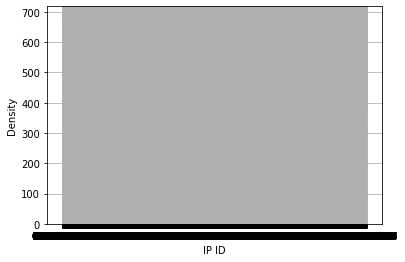

In [34]:
plt.scatter(non_rst_packets.ipid, streams.initial_rtt, marker=".")
plt.xlabel("Time Epoch of first packet")
plt.ylabel("Initial RTT")
plt.title("Plot of initial RTT vs time")

Text(0, 0.5, 'Density')

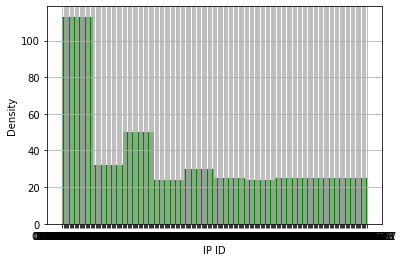

In [35]:
rst_packets.ipid.hist(color="green")
plt.xlabel('IP ID'); plt.ylabel('Density')